In [1]:
!pip install vnstock3 pandas_ta tensorflow scikit-learn


[notice] A new release of pip is available: 23.3.2 -> 24.1.1
[notice] To update, run: C:\Users\thien\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [14]:
import os
# Set environment variable
if "ACCEPT_TC" not in os.environ:
    os.environ["ACCEPT_TC"] = "tôi đồng ý"
from datetime import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from vnstock3 import Vnstock
import pandas_ta as ta
from sklearn.preprocessing import StandardScaler
import F  # Assuming 'F' is a module you've created
import matplotlib.pyplot as plt

In [15]:
# Get current date
now = datetime.now()
current_date = now.strftime("%Y-%m-%d")

# Fetch VN30 and VNI stock data
vn30 = Vnstock().stock(symbol='VN30', source='VCI')
df_vn30 = vn30.quote.history(start='2020-08-01', end=current_date, to_df=True)

vni = Vnstock().stock(symbol='VNINDEX', source='VCI')
df_vni = vni.quote.history(start='2020-08-01', end=current_date, to_df=True)

2024-07-06 14:24:52,590 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS
2024-07-06 14:24:53,836 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS


In [16]:
# Function to process data
def process_data(data):
    data['time'] = pd.to_datetime(data['time'])
    data.sort_values(by='time', ascending=True, inplace=True)
    data.reset_index(drop=True, inplace=True)
    
    data['close'] = pd.to_numeric(data['close'], errors='coerce')
    data['sma5'] = ta.sma(data['close'], length=5)
    data['sma10'] = ta.sma(data['close'], length=10)
    data['ema5'] = ta.ema(data['close'], length=5)
    data['ema10'] = ta.ema(data['close'], length=10)
    data['rsi'] = ta.rsi(data['close'], length=14)
    data.ta.macd(close='close', fast=12, slow=26, signal=9, append=True)

    data.dropna(inplace=True)
    data.reset_index(drop=True, inplace=True)
    return data

# Process the VN30 and VNI data
data_VN30 = process_data(df_vn30)
data_VNI = process_data(df_vni)

# Function to create LSTM model
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(100, return_sequences=True, input_shape=input_shape),
        LSTM(100),
        Dense(1)
    ])
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Function to prepare data for LSTM model
def prepare_data(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), :])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Function to train LSTM model
def model_LSTM(data, time_steps=60, epochs=50, batch_size=64):
    data_features = data[['close', 'sma5', 'sma10', 'ema5', 'ema10', 'rsi', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9']].values
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_features)
    
    X, y = prepare_data(data_scaled, time_steps)
    X = X.reshape(X.shape[0], X.shape[1], data_features.shape[1])
    
    model = create_lstm_model((time_steps, data_features.shape[1]))
    model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1)
    return model, scaler, time_steps

# Function to get prediction from LSTM model
def output_LSTM(model, scaler, data, time_steps=60):
    data_features = data[['close', 'sma5', 'sma10', 'ema5', 'ema10', 'rsi', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9']].values
    data_scaled = scaler.transform(data_features)
    
    X = np.array([data_scaled[-time_steps:]])
    X = X.reshape(X.shape[0], X.shape[1], data_features.shape[1])
    
    predicted_price = model.predict(X)
    predicted_price = scaler.inverse_transform(np.concatenate([predicted_price, np.zeros((predicted_price.shape[0], data_features.shape[1]-1))], axis=1))[:, 0]
    
    return predicted_price[0]

# Backtesting function
def test(data, k):
    data_output = data[['time', 'close']].copy()
    data_output['position'] = 0

    # Initialize model
    model_lstm, scaler_lstm, time_steps_lstm = model_LSTM(data, time_steps=k)
    
    for i in range(k, len(data)):
        historical_data = data.iloc[i-k:i]
        
        lstm_pred = output_LSTM(model_lstm, scaler_lstm, historical_data, time_steps_lstm)
        
        predictions = lstm_pred - data.iloc[i-1]['close']
        
        data_output.loc[i, 'position'] = 1 if predictions > 2 else (-1 if predictions < -2 else 0)
    
    data_output.dropna(inplace=True)
    return data_output

# Plotting function for PNL with annotation
def plot_pnl_with_annotation(data, symbol):
    backtesting = F.BacktestInformation(data['time'], data['position'], data['close'])
    pnl_data = backtesting.Plot_PNL(plot=False)
    
    # Plot PNL
    plt.figure(figsize=(15, 6))
    pnl_data['total_gain'].plot(label='Total Gain')
    pnl_data['total_gain_after_fee'].plot(label='Total Gain After Fee')

    plt.title(f'PNL for {symbol}')
    plt.xlabel('Time')
    plt.ylabel('PNL')
    plt.legend()
    plt.grid(True)
    plt.annotate(f'Stock: {symbol}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12,
                 bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))
    plt.show()

Epoch 1/50
14/14 [==============================] - 8s 168ms/step - loss: 0.1879
Epoch 2/50
14/14 [==============================] - 2s 150ms/step - loss: 0.0449
Epoch 3/50
14/14 [==============================] - 2s 150ms/step - loss: 0.0301
Epoch 4/50
14/14 [==============================] - 2s 155ms/step - loss: 0.0257
Epoch 5/50
14/14 [==============================] - 2s 153ms/step - loss: 0.0239
Epoch 6/50
14/14 [==============================] - 2s 151ms/step - loss: 0.0221
Epoch 7/50
14/14 [==============================] - 2s 151ms/step - loss: 0.0208
Epoch 8/50
14/14 [==============================] - 2s 157ms/step - loss: 0.0191
Epoch 9/50
14/14 [==============================] - 2s 160ms/step - loss: 0.0189
Epoch 10/50
14/14 [==============================] - 2s 167ms/step - loss: 0.0180
Epoch 11/50
14/14 [==============================] - 2s 174ms/step - loss: 0.0173
Epoch 12/50
14/14 [==============================] - 2s 171ms/step - loss: 0.0168
Epoch 13/50
14/14 [======

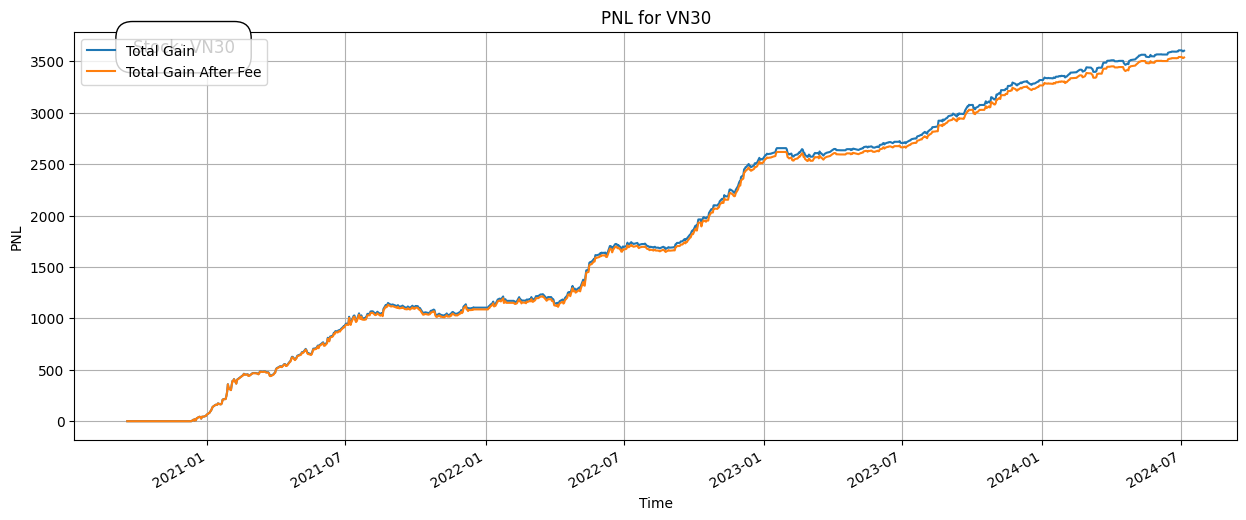

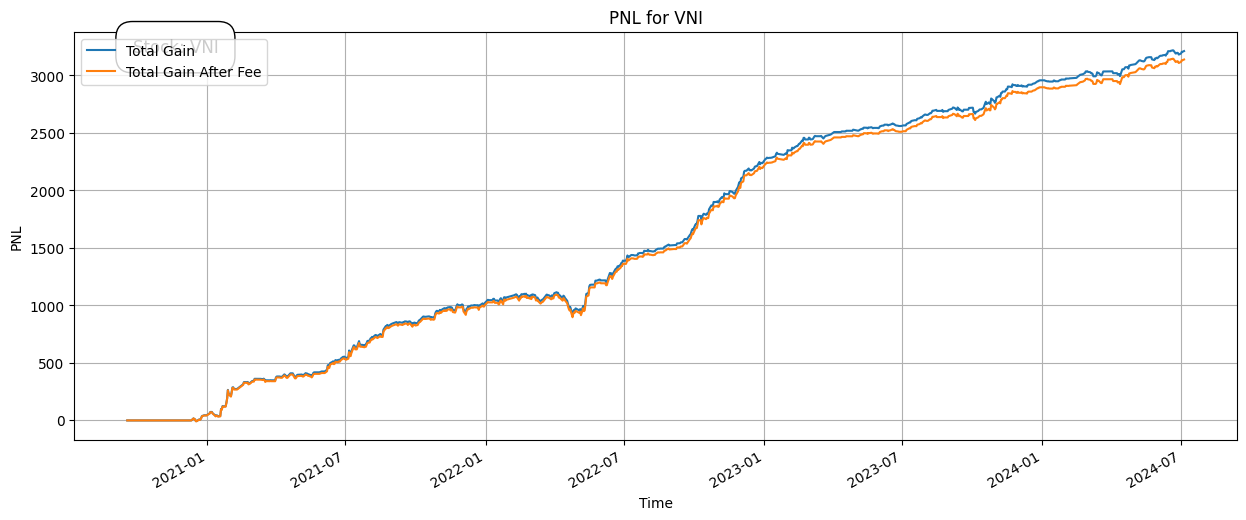

Backtesting Results for VN30
Margin: 95.12501301608674
MDD: (164.64802742616075, 0.10470729139447792)

   Total trading quantity: 151
         Profit per trade: 23.85516556291392
             Total Profit: 3602.1
         Profit after fee: 3536.7
 Trading quantity per day: 0.15928270042194093
 Profit per day after fee: 3.7306962025316452
                   Return: 0.5918818452080113
          Profit per year: 930.7105263157895
                  HitRate: 0.7086092715231788
          HitRate per day: 0.5036958817317846


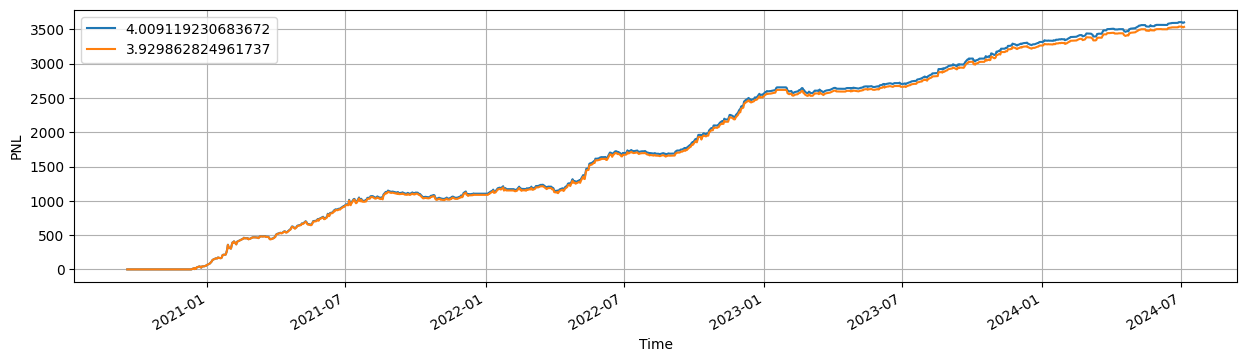

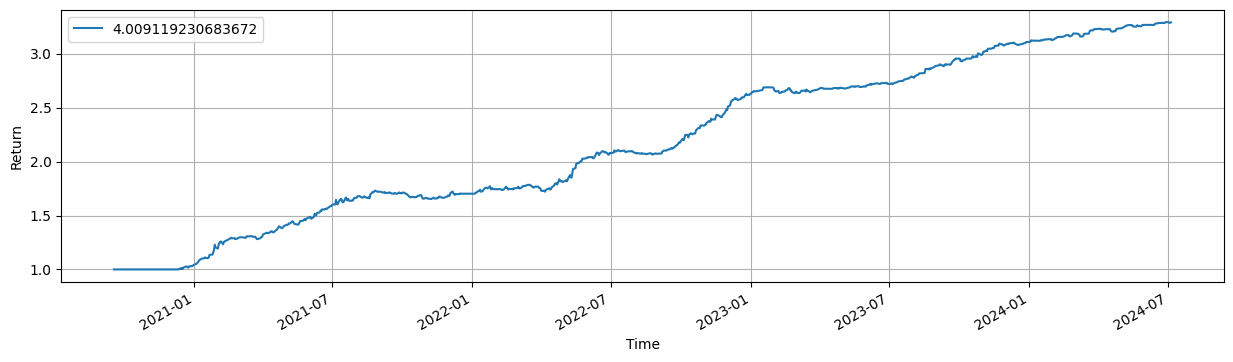

Backtesting Results for VNI
Margin: 80.12112376380661
MDD: (85.17797468354456, 0.055931429958332494)

   Total trading quantity: 168
         Profit per trade: 19.121845238095222
             Total Profit: 3212.5
         Profit after fee: 3138.9
 Trading quantity per day: 0.17721518987341772
 Profit per day after fee: 3.3110759493670887
                   Return: 0.5424035168359536
          Profit per year: 826.0263157894738
                  HitRate: 0.7678571428571429
          HitRate per day: 0.4614572333685322


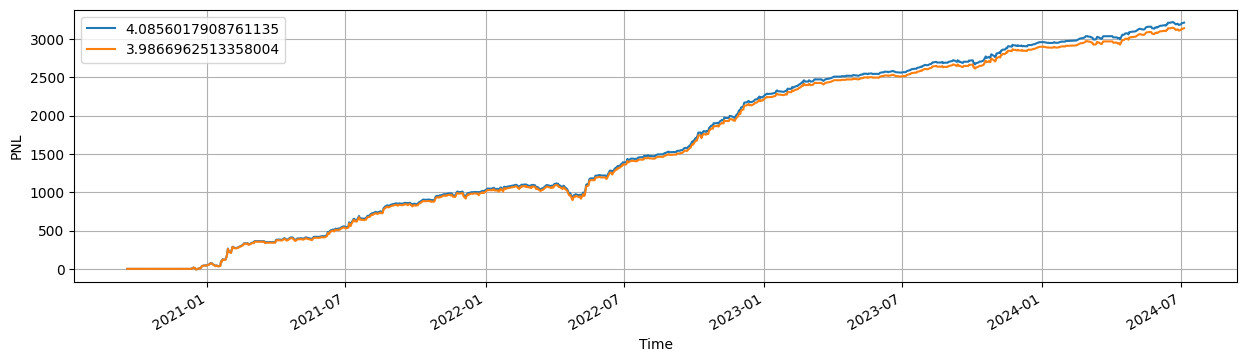

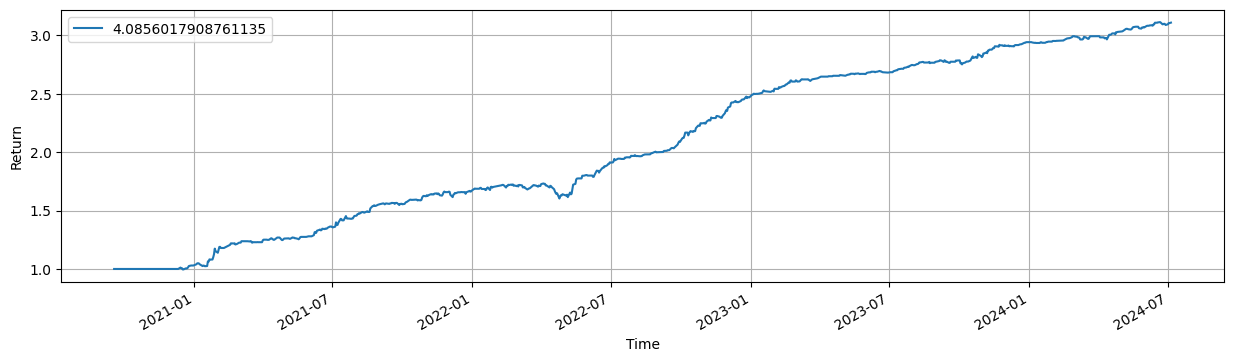

,total_gain,fee,total_gain_after_fee,Position,Close,Return
Datetime,,,,,,
2020-09-18,0.00,0.000000,0.000000,0,900.95,1.000000
2020-09-21,0.00,0.000000,0.000000,0,907.94,1.000000
2020-09-22,0.00,0.000000,0.000000,0,906.19,1.000000
2020-09-23,0.00,0.000000,0.000000,0,912.50,1.000000
2020-09-24,0.00,0.000000,0.000000,0,908.58,1.000000
...,...,...,...,...,...,...
2024-07-01,3191.05,73.091392,3117.958608,1,1254.56,3.095377
2024-07-02,3206.28,73.310886,3132.969114,0,1269.79,3.105378
2024-07-03,3206.28,73.530380,3132.749620,1,1276.85,3.105378


In [17]:
# Run the backtesting for VN30 and VNI
data_VNI_position = test(data_VNI, 60)
data_VN30_position = test(data_VN30, 60)

plot_pnl_with_annotation(data_VN30_position, 'VN30')
plot_pnl_with_annotation(data_VNI_position, 'VNI')

# Print backtesting results
backtesting_VN30 = F.BacktestInformation(data_VN30_position['time'], data_VN30_position['position'], data_VN30_position['close'])
backtesting_VNI = F.BacktestInformation(data_VNI_position['time'], data_VNI_position['position'], data_VNI_position['close'])

print("Backtesting Results for VN30")
backtesting_VN30.Plot_PNL()

print("Backtesting Results for VNI")
backtesting_VNI.Plot_PNL()